In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import argparse
import glob
import os
import pickle
import my_utils
from tqdm import tqdm
from torch import nn, einsum
from torch.optim import AdamW
from torch.optim import SGD
from torchmetrics import Accuracy
from torch.optim import Adam
from torchvision import datasets, transforms
from sklearn.cluster import KMeans
import torch.nn.functional as F
from torch.utils.data import random_split
from sklearn.decomposition import PCA
from einops import rearrange, repeat
from vision_transformer_cp import DINOHead, vit_small, vit_tiny, vit_base, vit_tinyer, vit_tiniest


f:\Machine learning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class DINO(nn.Module):
    def __init__(self, out_dim=768, use_bn=False, model_type="tiny"):
        super().__init__()
        model_map = {'tiny':vit_tiny(), 'small':vit_small(), 'base':vit_base(),
                     'vit_tinyer':vit_tinyer()
                    }
        # Student network
        self.student = model_map[model_type]
        embed_dim = self.student.embed_dim
        
        self.student = nn.Sequential(
            self.student,
            DINOHead(embed_dim, out_dim, use_bn)
        )
        # Teacher network
        self.teacher = model_map[model_type]
        self.teacher = nn.Sequential(
            self.teacher,
            DINOHead(embed_dim, out_dim, use_bn)
        )
        # Initialize teacher and student with same weights
        self.teacher.load_state_dict(self.student.state_dict())
        # Turn off gradients for teacher network
        for param in self.teacher.parameters():
            param.requires_grad = False

    def forward(self, x, is_teacher=False):
        # Forward pass through Perceiver
        batch_size = x.shape[0]
        x = self.student[0](x) if not is_teacher else self.teacher[0](x)
        # combine latents
        x = x.view(batch_size, 1, -1)
        x = self.student[1](x) if not is_teacher else self.teacher[1](x)
        return x
    def update_teacher(self, momentum=0.996):
        # EMA update
        for param_q, param_k in zip(self.student.parameters(), self.teacher.parameters()):
            param_k.data = param_k.data * momentum + param_q.data * (1. - momentum)
    def get_last_selfattention(self, x):
        return self.student[0].get_last_selfattention(x)
    def extract_features(self, x, is_teacher=False):
        # Use forward to get embeddings
        with torch.no_grad():
            x = self.forward(x, is_teacher=is_teacher)  # (B, 1, out_dim)
        # Remove the extra dimension
        return x.squeeze(1)  # shape: (B, out_dim)


In [3]:
class DINOLoss(nn.Module):
    def __init__(self, out_dim, ncrops, warmup_teacher_temp, teacher_temp,
                 warmup_teacher_temp_epochs, nepochs, student_temp=0.1,
                 center_momentum=0.9):
        super().__init__()
        self.student_temp = student_temp
        self.center_momentum = center_momentum
        self.ncrops = ncrops
        self.register_buffer("center", torch.zeros(1, out_dim))
        self.teacher_temp_schedule = np.concatenate((
            np.linspace(warmup_teacher_temp, teacher_temp, warmup_teacher_temp_epochs),
            np.ones(nepochs - warmup_teacher_temp_epochs) * teacher_temp
        ))

    def forward(self, student_output, teacher_output, epoch):
        dino_loss = self.compute_dino_loss(student_output, teacher_output, epoch)
        # Combine the DINO loss and the energy loss
        total_loss = dino_loss
        self.update_center(teacher_output)
        return total_loss

    def compute_dino_loss(self, student_output, teacher_output, epoch):
        self.center = self.center.to(student_output.device)
        student_out = student_output / self.student_temp
        student_out = student_out.chunk(self.ncrops)
        temp = self.teacher_temp_schedule[epoch]
        teacher_out = F.softmax((teacher_output - self.center) / temp, dim=-1)
        teacher_out = teacher_out.detach().chunk(2)
        total_loss = 0
        n_loss_terms = 0
        for iq, q in enumerate(teacher_out):
            for v in range(len(student_out)):
                if v == iq:
                    continue
                loss = torch.sum(-q * F.log_softmax(student_out[v], dim=-1), dim=-1)
                total_loss += loss.mean()
                n_loss_terms += 1
        total_loss /= n_loss_terms
        return total_loss

    @torch.no_grad()
    def update_center(self, teacher_output):
        batch_center = torch.sum(teacher_output, dim=0, keepdim=True)
        batch_center = batch_center / len(teacher_output)
        self.center = self.center * self.center_momentum + batch_center * (1 - self.center_momentum)

In [5]:
class DataAugmentationDINO(object):
    def __init__(self, global_crops_scale, local_crops_scale, local_crops_number, image_size=28):
        flip_and_color_jitter = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(
                [transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)],
                p=0.8
            ),
            transforms.RandomGrayscale(p=0.2),
        ])
        self.image_size = image_size

        self.normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),  # MNIST normalization
        ])

        # first global crop
        self.global_transfo1 = transforms.Compose([
            transforms.RandomResizedCrop(image_size, scale=global_crops_scale),
            flip_and_color_jitter,
            self.normalize,
        ])
        # second global crop
        self.global_transfo2 = transforms.Compose([
            transforms.RandomResizedCrop(image_size, scale=global_crops_scale),
            flip_and_color_jitter,
            self.normalize,
        ])
        # transformation for the local small crops
        self.local_crops_number = local_crops_number
        self.local_transfo = transforms.Compose([
            transforms.RandomResizedCrop(image_size, scale=local_crops_scale),
            flip_and_color_jitter,
            self.normalize,
        ])

    def __call__(self, image):
        crops = []
        crops.append(self.global_transfo1(image))
        crops.append(self.global_transfo2(image))
        for _ in range(self.local_crops_number):
            crops.append(self.local_transfo(image))
        # Transform the original image to tensor
        unaugmented_image = image.resize((self.image_size, self.image_size))
        unaugmented_image = self.normalize(unaugmented_image)
        #print(f"Unaugmented image shape: {unaugmented_image.shape}")
        return (unaugmented_image, crops)  # Return a tuple of unaugmented image and list of crops


In [6]:
class WSITileDataset(Dataset):
    def __init__(self, tiles_dir="tiles", transform=None):
        super().__init__()
        self.tiles_dir = tiles_dir
        self.transform = transform
        self.filepaths = []
        for fname in os.listdir(tiles_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.tif')):
                # Assuming a filename format: tile_x_y.png
                # Modify this pattern if your filenames differ
                base, ext = os.path.splitext(fname)
                # e.g., base = "tile_3_5"
                parts = base.split('_')
                if len(parts) >= 3:
                    # The last two parts are x and y coordinates
                    x_idx = int(parts[-2])
                    y_idx = int(parts[-1])
                    fpath = os.path.join(tiles_dir, fname)
                    self.filepaths.append((fpath, x_idx, y_idx))
                else:
                    # If the filename doesn't follow the pattern,
                    # either skip it or handle differently.
                    pass

        # Sort by coordinates if desired (optional)
        self.filepaths.sort(key=lambda x: (x[2], x[1]))  # sort by y, then x

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        fpath, x_idx, y_idx = self.filepaths[idx]
        img = Image.open(fpath).convert("RGB")
        if self.transform:
            img = self.transform(img)
        # Return image and coordinates
        return img, (x_idx, y_idx)

In [7]:
image_size = 224  # Adjust as needed
global_crops_scale = (0.4, 1.0)
local_crops_scale = (0.05, 0.4)
local_crops_number = 4

dino_transform = DataAugmentationDINO(global_crops_scale, local_crops_scale, local_crops_number, image_size=image_size)
dataset = WSITileDataset("F:/Machine learning/basic_normalized_tiles", transform=dino_transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True,pin_memory=True)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DINO(out_dim=768, model_type='base').to(device)
optimizer = torch.optim.Adam(model.student.parameters(), lr=0.0005)
model.eval()

f:\Machine learning\.venv\Lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


DINO(
  (student): Sequential(
    (0): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (act): GELU(approximate='none')
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (drop): Dropout(p=0.0, in

In [9]:
epochs = 2
ncrops = 2 + local_crops_number # 2 global + local_crops_number local
criterion = DINOLoss(out_dim=768, ncrops=ncrops, warmup_teacher_temp=0.04, 
                     teacher_temp=0.07, warmup_teacher_temp_epochs=1, 
                     nepochs=epochs, student_temp=0.1, center_momentum=0.9)

In [10]:
model.train()
for epoch in range(epochs):
    for i, (data_tuple, _) in enumerate(loader):
        unaugmented_image, crops = data_tuple
        # crops: list of length ncrops with tensors of shape (B, C, H, W)
        # Concatenate all crops for student
        all_crops = torch.cat(crops, dim=0).to(device)   # (B*ncrops, C, H, W)
        teacher_inp = torch.cat(crops[:2], dim=0).to(device) # 2 global crops for teacher

        student_output = model(all_crops, is_teacher=False).squeeze(1)  # (B*ncrops, out_dim)
        teacher_output = model(teacher_inp, is_teacher=True).squeeze(1) # (B*2, out_dim)

        loss = criterion(student_output, teacher_output, epoch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.update_teacher(momentum=0.996)

        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i}/{len(loader)}], Loss: {loss.item():.4f}")

print("Training complete.")

Epoch [1/2], Step [0/65], Loss: 6.0651
Epoch [1/2], Step [10/65], Loss: 6.4180
Epoch [1/2], Step [20/65], Loss: 6.5769
Epoch [1/2], Step [30/65], Loss: 6.6245
Epoch [1/2], Step [40/65], Loss: 6.6355
Epoch [1/2], Step [50/65], Loss: 6.6373
Epoch [1/2], Step [60/65], Loss: 6.6387
Epoch [2/2], Step [0/65], Loss: 6.6429
Epoch [2/2], Step [10/65], Loss: 6.6427
Epoch [2/2], Step [20/65], Loss: 6.6426
Epoch [2/2], Step [30/65], Loss: 6.6422
Epoch [2/2], Step [40/65], Loss: 6.6423
Epoch [2/2], Step [50/65], Loss: 6.6426
Epoch [2/2], Step [60/65], Loss: 6.6423
Training complete.


In [ ]:
model.eval()  # Put the model in evaluation mode
inference_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
# Prepare a dataset (same transforms as needed) for inference
inference_dataset = WSITileDataset("F:/Machine learning/basic_normalized_tiles", transform=inference_transform)
inference_loader = DataLoader(inference_dataset, batch_size=32, shuffle=False)

all_embeddings = []
tile_coords = []

# Disable gradient computation for inference
with torch.no_grad():
    for batch_idx, (images, coords) in enumerate(inference_loader):
        # Move images to the designated device (GPU)
        images = images.to(device)
        
        # Extract features using the student model (set is_teacher=True if using the teacher model)
        emb = model.extract_features(images, is_teacher=True)  # Shape: (B, out_dim)
        
        # Process coordinates
        if isinstance(coords, torch.Tensor):
            # Case 1: coords is a single tensor, likely of shape (2, B) or (B, 2)
            if coords.ndim == 2:
                if coords.size(0) == 2:
                    # Shape: (2, B) - First row is x, second row is y
                    x_tensor, y_tensor = coords
                    x_coords = x_tensor.tolist()
                    y_coords = y_tensor.tolist()
                elif coords.size(1) == 2:
                    # Shape: (B, 2) - Each row is [x, y]
                    x_coords = coords[:, 0].tolist()
                    y_coords = coords[:, 1].tolist()
                else:
                    print(f"Batch {batch_idx}: Unexpected tensor shape for coords: {coords.shape}")
                    continue  # Skip this batch
            else:
                print(f"Batch {batch_idx}: Unexpected tensor dimensionality for coords: {coords.ndim}")
                continue  # Skip this batch
            
            # Pair x and y coordinates
            coords_list = list(zip(x_coords, y_coords))
        
        elif isinstance(coords, (list, tuple)) and len(coords) == 2 and all(isinstance(t, torch.Tensor) for t in coords):
            # Case 2: coords is a list or tuple of two tensors: [x_tensor, y_tensor]
            x_tensor, y_tensor = coords
            x_coords = x_tensor.tolist()
            y_coords = y_tensor.tolist()
            
            # Ensure both tensors have the same length
            if len(x_coords) != len(y_coords):
                print(f"Batch {batch_idx}: Mismatch in number of x and y coordinates ({len(x_coords)} vs {len(y_coords)})")
                continue  # Skip this batch
            
            # Pair x and y coordinates
            coords_list = list(zip(x_coords, y_coords))
        
        elif isinstance(coords, (list, tuple)) and len(coords) == 2 and all(isinstance(c, int) for c in coords):
            # Case 3: coords is a single (x, y) pair
            coords_list = [tuple(coords)]
        
        else:
            # Case 4: Unexpected format
            print(f"Batch {batch_idx}: Unexpected coords format:", coords)
            continue  # Skip this batch or handle as needed
        
        # Extend the tile_coords with the paired (x, y) tuples
        tile_coords.extend(coords_list)
        
        # Append the embeddings to the all_embeddings list
        all_embeddings.append(emb.cpu())

# Concatenate all embeddings into a single NumPy array
all_embeddings = torch.cat(all_embeddings, dim=0).numpy()  # Shape: (N, out_dim)


# For example, using a specific dimension from the embeddings
meaningful_dim = 0  # Replace with the actual dimension you're interested in
feature_values = np.mean(all_embeddings, axis=1)
feature=all_embeddings[:, meaningful_dim] 
#pca = PCA(n_components=2)
#feature_values = pca.fit_transform(all_embeddings).ravel()  # should give (2106,)

After PCA: (2106,)
After scaling: (2106,)


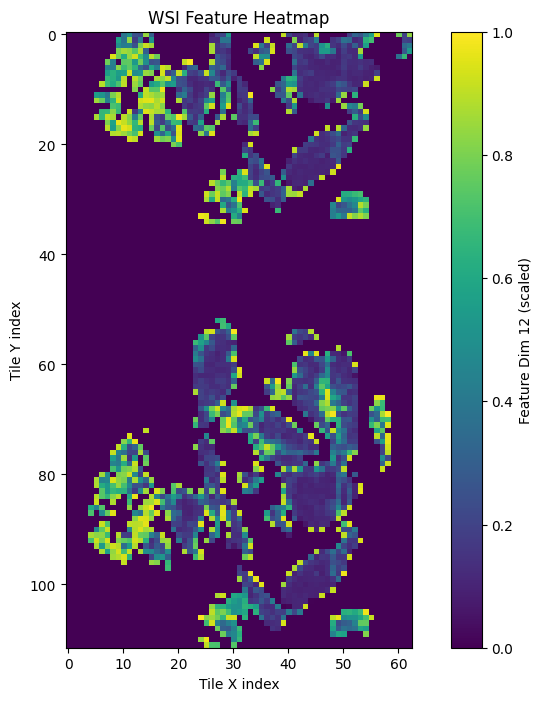

In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_values_scaled = scaler.fit_transform(feature_values.reshape(-1, 1)).ravel()  # still (2106,)
# 5. Map the feature values back onto the WSI layout
W = max(x for x,y in tile_coords) + 1
H = max(y for x,y in tile_coords) + 1
print("After PCA:", feature_values.shape)    # should be (2106,)
print("After scaling:", feature_values_scaled.shape)  # should be (2106,)
feature_map = np.zeros((H, W))
for i, (x_idx, y_idx) in enumerate(tile_coords):
    feature_map[y_idx, x_idx] = feature_values_scaled[i]

# 6. Visualize the heatmap
plt.figure(figsize=(10,8))
plt.imshow(feature_map, cmap='viridis')
plt.colorbar(label=f'Feature Dim {meaningful_dim} (scaled)')
plt.title('WSI Feature Heatmap')
plt.xlabel('Tile X index')
plt.ylabel('Tile Y index')
plt.show()



In [13]:
print("Number of embeddings:", all_embeddings.shape[0])
print("Number of coordinates:", len(tile_coords))
print("Number of feature values:", len(feature_values_scaled))


Number of embeddings: 2106
Number of coordinates: 2106
Number of feature values: 2106


In [14]:
assert len(tile_coords) == all_embeddings.shape[0], "Mismatch in number of tiles and embeddings"
assert len(feature_values_scaled) == all_embeddings.shape[0], "Mismatch in feature values and embeddings"

In [15]:
# Define the number of top features to highlight
top_n = 2  # You can adjust this number

# Get the indices of the top-N feature values
top_indices = np.argsort(feature_values_scaled)[-top_n:]

# Retrieve the corresponding (x, y) coordinates
top_coords = [tile_coords[i] for i in top_indices]

print(f"Top-{top_n} feature coordinates:")
for coord in top_coords:
    print(coord)

Top-2 feature coordinates:
(24, 106)
(58, 69)


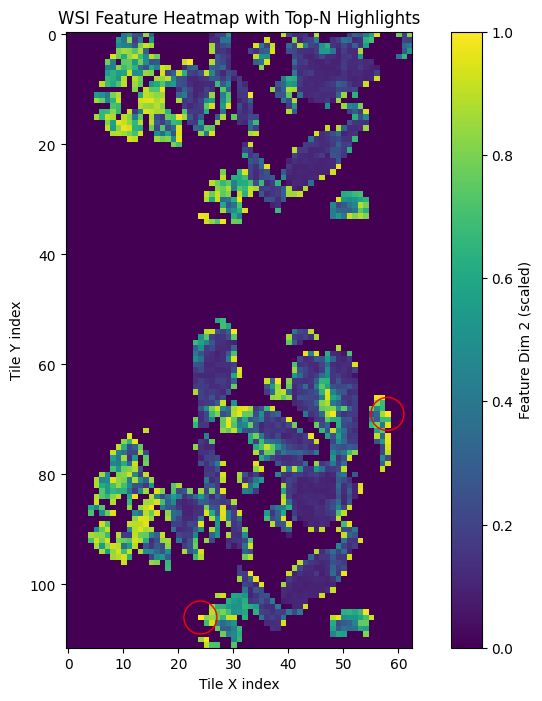

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(feature_map, cmap='viridis')
plt.colorbar(label=f'Feature Dim {meaningful_dim} (scaled)')
plt.title('WSI Feature Heatmap with Top-N Highlights')
plt.xlabel('Tile X index')
plt.ylabel('Tile Y index')

# Get the current axes
ax = plt.gca()

# Define the radius of the circles (adjust based on your tile size and heatmap resolution)
circle_radius = 3  # Adjust as necessary

# Draw circles around top-N features
for (x, y) in top_coords:
    circ = patches.Circle((x, y), radius=circle_radius, linewidth=1, edgecolor='red', facecolor='none')
    ax.add_patch(circ)

plt.show()


In [17]:
# (Optional) Pinpoint tiles with top feature values
# For example, find top 5 tiles that have the highest feature values
top_k = 5
top_indices = np.argsort(feature_values)[-top_k:]
print("Top tiles with highest feature dimension values:")
for idx in top_indices:
    x_idx, y_idx = tile_coords[idx]
    print(f"Tile at (x={x_idx}, y={y_idx}) with feature value: {feature_values[idx]:.4f}")

Top tiles with highest feature dimension values:
Tile at (x=38, y=63) with feature value: 0.0144
Tile at (x=30, y=54) with feature value: 0.0144
Tile at (x=22, y=5) with feature value: 0.0144
Tile at (x=24, y=106) with feature value: 0.0144
Tile at (x=58, y=69) with feature value: 0.0144


In [18]:
import gc
gc.collect()


5250

In [19]:
import openslide
from PIL import Image

# Replace with your WSI file path
wsi_path = "006388_0.tif"
slide = openslide.OpenSlide(wsi_path)

# Read a region or the whole slide (be cautious with memory)
# Here, we'll read a downsampled version for visualization
level = 0 # Level 0 is the highest resolution
slide_dimensions = slide.level_dimensions[level]
wsi_image = slide.read_region((0, 0), level, slide_dimensions).convert('RGB')

# Convert to NumPy array
wsi_np = np.array(wsi_image)


In [20]:
gc.collect()

7